## Import Library

In [1]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [2]:
# !pip install transformers

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os
import glob
import shutil
import random
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torch.utils.tensorboard import SummaryWriter

import albumentations as A
from albumentations.pytorch import ToTensorV2
from transformers import get_cosine_schedule_with_warmup
from transformers import SegformerForSemanticSegmentation

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"


## Class Dataset

In [5]:
class BreastCancerDataset(Dataset):
    def __init__(self, paths, transform=None):
        self.path = paths
        self.transform = transform
        self.categories = ["benign", "malignant", "normal"]
    # def __init__(self, root='/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT', split="train", transform=None):
    #     self.categories = ["benign", "malignant", "normal"]
    #     self.transform = transform

    #     # collect all mask paths
    #     all_paths = glob.glob(f"{root}/*/*_mask.png")

    #     # extract labels from folder names
    #     labels = [p.split("/")[-2] for p in all_paths]  

    #     # stratified split
    #     train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    #         all_paths, labels, test_size=0.30, random_state=159, stratify=labels
    #     )
    #     val_paths, test_paths, _, _ = train_test_split(
    #         temp_paths, temp_labels, test_size=0.50, random_state=159, stratify=temp_labels
    #     )

    #     ###################
    #     self.path = glob.glob("{}/*/*_mask.png".format(root))

    #     random.seed(159)
    #     random.shuffle(self.path)

    #     total_len = len(self.path)
    #     train_end = int(total_len * 0.70)
    #     val_end = int(total_len * 0.85)
    #     if split == "train":
    #         self.path = self.path[:train_end]
    #     elif split == "val":
    #         self.path = self.path[train_end:val_end]
    #     elif split == "test":
    #         self.path = self.path[val_end:]
    #     else:
    #         raise ValueError("split must be 'train', 'val', or 'test'")
    
    def __len__(self):
        return len(self.path)
    
    def __getitem__(self, index):
        image = cv2.imread(self.path[index].replace("_mask.png", ".png"))
        mask = cv2.imread(self.path[index], cv2.IMREAD_GRAYSCALE)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask[mask == 255] = 1

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]

        return image.float(), mask.float()

In [6]:
size = 512
train_transform = A.Compose([
    A.Resize(size, size),
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    A.HorizontalFlip(),
    A.Perspective(scale=(0.05, 0.1)),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2()
])
    # A.RandomRotate90(),
    # A.GaussianBlur(),
    # A.CoarseDropout(max_height=25, max_width=25, fill_value=255),
    # A.ElasticTransform(alpha=1.0),

test_transform = A.Compose([
    A.Resize(size, size),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2()
])

## UnNormalized

In [7]:
class UnNormalized(object):
    def __init__(self, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
        self.mean = mean
        self.std = std
    
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

unNorm = UnNormalized()

In [8]:
root='/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
all_paths = glob.glob(f"{root}/*/*_mask.png")
labels = [p.split("/")[-2] for p in all_paths]

train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_paths, labels, test_size=0.30, random_state=159, stratify=labels
)
val_paths, test_paths, _, _ = train_test_split(
    temp_paths, temp_labels, test_size=0.50, random_state=159, stratify=temp_labels
)

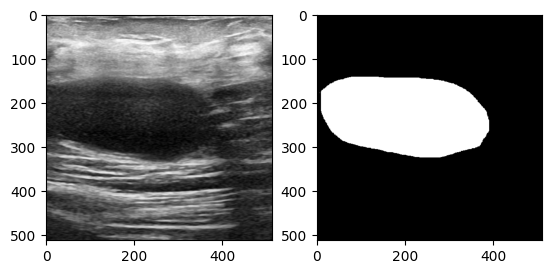

In [9]:
train_dataset = BreastCancerDataset(paths=train_paths, transform=train_transform)
val_dataset = BreastCancerDataset(paths=val_paths, transform=test_transform)
test_dataset = BreastCancerDataset(paths=test_paths, transform=test_transform)

image, mask = train_dataset[random.randint(1, len(train_dataset))]
plt.subplot(1, 2, 1)
plt.imshow(unNorm(image).permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.show()

## AverageMeter

In [10]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n = 1):
        self.val += val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Show Loss

In [11]:
def plot_segmentation_metrics(train_loss, val_loss, train_mean_iou=None, val_mean_iou=None, 
                              train_dice_score=None, val_dice_score=None):
    """
    Plot training and validation metrics (loss, mean IoU, Dice score) over epochs.

    Args:
    - train_loss (list): List of training loss values over epochs.
    - val_loss (list): List of validation loss values over epochs.
    - train_mean_iou (list, optional): List of training mean IoU values over epochs.
    - val_mean_iou (list, optional): List of validation mean IoU values over epochs.
    - train_dice_score (list, optional): List of training Dice score values over epochs.
    - val_dice_score (list, optional): List of validation Dice score values over epochs.
    """
    epochs = range(1, len(train_loss) + 1)
    
    plt.figure(figsize=(15, 10))
    
    # Plotting the Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Val Loss')
    plt.title('Training and Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plotting the Mean IoU (if available)
    if train_mean_iou:
        plt.subplot(2, 2, 2)
        plt.plot(epochs, train_mean_iou, 'r', label='Training Mean IoU')
    if val_mean_iou:
        plt.subplot(2, 2, 2)
        plt.plot(epochs, val_mean_iou, 'b', label='Val Mean IoU')
        plt.title('Training and Val Mean IoU')
        plt.xlabel('Epochs')
        plt.ylabel('Mean IoU')
        plt.legend()
    
    # Plotting the Dice Score (if available)
    if train_dice_score:
        plt.subplot(2, 2, 3)
        plt.plot(epochs, train_dice_score, 'r', label='Training Dice Score')
    if val_dice_score:
        plt.subplot(2, 2, 3)
        plt.plot(epochs, val_dice_score, 'b', label='Val Dice Score')
        plt.title('Training and Val Dice Score')
        plt.xlabel('Epochs')
        plt.ylabel('Dice Score')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

## Calculate Intersection And Union

In [12]:
def intersectionAndUnionGPU(output, target, K, ignore_index=255):
    # 'K' classes, output and target sizes are N or N * L or N * H * W, each value in range 0 to K - 1.
    assert (output.dim() in [1, 2, 3])
    assert output.shape == target.shape
    output = output.view(-1)
    target = target.view(-1)
    output[target == ignore_index] = ignore_index
    intersection = output[output == target]
    area_intersection = torch.histc(intersection, bins=K, min=0, max=K-1)
    area_output = torch.histc(output, bins=K, min=0, max=K-1)
    area_target = torch.histc(target, bins=K, min=0, max=K-1)
    area_union = area_output + area_target - area_intersection
    return area_intersection, area_union, area_target

## Train

In [13]:
upsample = nn.Upsample(scale_factor=4, mode='bilinear')

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [15]:
def train(train_dataset, val_dataset, num_class, n_workers, batch_size, lr, epochs, checkpoint, saved_model):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # train_dataset = BreastCancerDataset(transform=train_transform)
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=n_workers
    )
    
    # val_dataset = BreastCancerDataset(is_train=False, transform=test_transform)
    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        num_workers=n_workers
    )

    version = "nvidia/segformer-b3-finetuned-ade-512-512"
    model = SegformerForSemanticSegmentation.from_pretrained(version)
    
    in_channels = model.decode_head.classifier.in_channels
    model.decode_head.classifier = nn.Conv2d(in_channels, num_class, 1, 1)
    model.to(device)
    
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr, weight_decay=1e-4)
    
    num_batch = len(train_loader)
    
    scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer, total_iters=num_batch*epochs, power=0.9)

    if os.path.isdir(checkpoint):
        shutil.rmtree(checkpoint)
    os.makedirs(checkpoint)
    
    if not os.path.isdir(saved_model):
        os.makedirs(saved_model)
    
    writer = SummaryWriter(checkpoint)
    
    train_loss = []
    val_loss = []
    val_mIoU = []
    val_mDice = []
    intersection_meter = AverageMeter()
    union_meter = AverageMeter()
    train_loss_meter = AverageMeter()
    val_loss_meter = AverageMeter()
    
    no_improvement_counter = 0
    patience = 5
    best_mIoU = -1
    
    for epoch in range(epochs):
        model.train()
        train_loss_meter.reset()
        val_loss_meter.reset()
        intersection_meter.reset()
        union_meter.reset()
        
        progress_bar = tqdm(train_loader, colour='cyan')
        
        for i, (image, mask) in enumerate(progress_bar):
            image, mask = image.to(device), mask.to(device)
            
            output = model(image).logits
            output = upsample(output).squeeze()
            loss = criterion(output, mask)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss_meter.update(loss.item())
            progress_bar.set_description(f"Train | Epoch {epoch + 1}/{epochs} | Loss {train_loss_meter.avg:.4f} | lr {optimizer.param_groups[0]['lr']}")
            writer.add_scalar("Train/Loss AVG", train_loss_meter.avg, num_batch * epoch + i)
            writer.add_scalar("Train/Loss", loss.item(), num_batch * epoch + i)
            scheduler.step()
        
        model.eval()
        with torch.no_grad():
            progress_bar = tqdm(iterable=val_loader, colour='yellow')
            
            for image, mask in progress_bar:
                image, mask = image.to(device), mask.to(device)
                
                output = model(image).logits
                output = upsample(output).squeeze()
                loss = criterion(output, mask)
                
                val_loss_meter.update(loss.item())
                output[output>=0.5] = 1
                output[output<0.5] = 0
                output = output.long()
                mask = mask.long()
                
                intersection, union, target = intersectionAndUnionGPU(output, mask, 2)           
                intersection_meter.update(intersection)
                union_meter.update(union)
                
                iou = intersection / (union + 1e-10)
                mean_iou = np.mean(iou.cpu().numpy())
                dice = 2 * intersection / (intersection + union + 1e-10)

                dice_value = dice.mean().item()
                
                intersection_meter.update(intersection)
                union_meter.update(union)
                val_loss_meter.update(loss.item())
                
                progress_bar.set_description(f"Val | Loss {loss.item():.4f} | mIoU: {mean_iou:.4f} | dice: {dice_value:.4f}")
            
            
            iou_class = intersection_meter.sum / (union_meter.sum + 1e-10)
            dice_class = 2 * intersection_meter.sum / (intersection_meter.sum + union_meter.sum + 1e-10)
            
            mIoU = iou_class.mean().item()
            mDice = dice_class.mean().item()
            print(f"Val | Loss {val_loss_meter.avg:.4f} | mIoU: {mIoU:.4f} | dice: {mDice:.4f}")
            
            writer.add_scalar("Val/Loss", val_loss_meter.avg, epoch)
            writer.add_scalar("Val/mIoU", mIoU, epoch)
            writer.add_scalar("Val/dice", mDice, epoch)
            
            checkpoint_data = {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epoch": epoch + 1,
                "mIoU": mIoU,
                "mDice": mDice
            }
            
            torch.save(checkpoint_data, os.path.join(saved_model, "last.pt"))
            
            if mIoU > best_mIoU:
                best_mIoU = mIoU
                torch.save(checkpoint_data, os.path.join(saved_model, "best.pt"))
                no_improvement_counter = 0
            else:
                no_improvement_counter += 1
              
            train_loss.append(train_loss_meter.avg)
            val_loss.append(val_loss_meter.avg)
            val_mIoU.append(mIoU)
            val_mDice.append(mDice)
            
            if no_improvement_counter > patience:
                print("Early stopping!")
                break
    
    plot_segmentation_metrics(train_loss, val_loss, None, val_mIoU, None, val_mDice)


In [16]:
import gc

for _ in range(3):
    torch.cuda.empty_cache()
    
    gc.collect()

6072

  0%|          | 0/69 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Train | Epoch 1/50 | Loss 0.4464 | lr 9.822432598564084e-05: 100%|██████████| 69/69 [03:06<00:00,  2.24s/it]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Train | Epoch 1/50 | Loss 0.4464 | lr 9.822432598564084e-05: 100%|██████████| 69/69 [03:06<00:00,  2.71s/it]
Val | Loss 0.1438 | mIoU: 0.8352 | dice: 0.9037: 100%|██████████| 15/15 [00:05<00:00,  2.50it/s]


Val | Loss 0.2289 | mIoU: 0.7421 | dice: 0.8352


Train | Epoch 2/50 | Loss 0.2124 | lr 9.641888539680158e-05: 100%|██████████| 69/69 [03:04<00:00,  2.67s/it]
Val | Loss 0.1127 | mIoU: 0.7040 | dice: 0.7988: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


Val | Loss 0.1342 | mIoU: 0.7091 | dice: 0.8046


Train | Epoch 3/50 | Loss 0.1490 | lr 9.460968040423652e-05: 100%|██████████| 69/69 [03:03<00:00,  2.66s/it]
Val | Loss 0.1456 | mIoU: 0.6637 | dice: 0.7614: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


Val | Loss 0.1413 | mIoU: 0.7511 | dice: 0.8417


Train | Epoch 4/50 | Loss 0.1297 | lr 9.279662282512714e-05: 100%|██████████| 69/69 [03:04<00:00,  2.68s/it]
Val | Loss 0.1009 | mIoU: 0.7536 | dice: 0.8428: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


Val | Loss 0.1316 | mIoU: 0.7814 | dice: 0.8654


Train | Epoch 5/50 | Loss 0.1052 | lr 9.097962044689201e-05: 100%|██████████| 69/69 [03:06<00:00,  2.70s/it]
Val | Loss 0.0892 | mIoU: 0.7093 | dice: 0.8038: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


Val | Loss 0.1128 | mIoU: 0.7806 | dice: 0.8647


Train | Epoch 6/50 | Loss 0.1079 | lr 8.915857674927509e-05: 100%|██████████| 69/69 [03:05<00:00,  2.69s/it]
Val | Loss 0.0789 | mIoU: 0.7526 | dice: 0.8416: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


Val | Loss 0.1126 | mIoU: 0.7653 | dice: 0.8528


Train | Epoch 7/50 | Loss 0.0883 | lr 8.733339060050722e-05: 100%|██████████| 69/69 [03:05<00:00,  2.69s/it]
Val | Loss 0.1083 | mIoU: 0.7099 | dice: 0.8045: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


Val | Loss 0.1007 | mIoU: 0.7931 | dice: 0.8741


Train | Epoch 8/50 | Loss 0.0839 | lr 8.55039559244599e-05: 100%|██████████| 69/69 [03:05<00:00,  2.68s/it] 
Val | Loss 0.1214 | mIoU: 0.7152 | dice: 0.8094: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


Val | Loss 0.1126 | mIoU: 0.7790 | dice: 0.8637


Train | Epoch 9/50 | Loss 0.0738 | lr 8.367016133526617e-05: 100%|██████████| 69/69 [03:05<00:00,  2.69s/it]
Val | Loss 0.1340 | mIoU: 0.7212 | dice: 0.8148: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


Val | Loss 0.1127 | mIoU: 0.7748 | dice: 0.8605


Train | Epoch 10/50 | Loss 0.0707 | lr 8.183188973535425e-05: 100%|██████████| 69/69 [03:05<00:00,  2.68s/it]
Val | Loss 0.1183 | mIoU: 0.6986 | dice: 0.7940: 100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


Val | Loss 0.1014 | mIoU: 0.7748 | dice: 0.8601


Train | Epoch 11/50 | Loss 0.0632 | lr 7.998901787222357e-05: 100%|██████████| 69/69 [03:05<00:00,  2.68s/it]
Val | Loss 0.1302 | mIoU: 0.7145 | dice: 0.8088: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


Val | Loss 0.1037 | mIoU: 0.7977 | dice: 0.8776


Train | Epoch 12/50 | Loss 0.0688 | lr 7.814141584855955e-05: 100%|██████████| 69/69 [03:04<00:00,  2.68s/it]
Val | Loss 0.0764 | mIoU: 0.7137 | dice: 0.8079: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


Val | Loss 0.1030 | mIoU: 0.7844 | dice: 0.8675


Train | Epoch 13/50 | Loss 0.0544 | lr 7.628894657941438e-05: 100%|██████████| 69/69 [03:05<00:00,  2.69s/it]
Val | Loss 0.0848 | mIoU: 0.7283 | dice: 0.8209: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


Val | Loss 0.1111 | mIoU: 0.7771 | dice: 0.8618


Train | Epoch 14/50 | Loss 0.0517 | lr 7.443146518914632e-05: 100%|██████████| 69/69 [03:05<00:00,  2.68s/it]
Val | Loss 0.0796 | mIoU: 0.7626 | dice: 0.8496: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


Val | Loss 0.1133 | mIoU: 0.7785 | dice: 0.8631


Train | Epoch 15/50 | Loss 0.0469 | lr 7.256881833956824e-05: 100%|██████████| 69/69 [03:05<00:00,  2.68s/it]
Val | Loss 0.0731 | mIoU: 0.7929 | dice: 0.8731: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


Val | Loss 0.1140 | mIoU: 0.7801 | dice: 0.8643


Train | Epoch 16/50 | Loss 0.0522 | lr 7.070084347926477e-05: 100%|██████████| 69/69 [03:05<00:00,  2.69s/it]
Val | Loss 0.0949 | mIoU: 0.7312 | dice: 0.8241: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


Val | Loss 0.1123 | mIoU: 0.7884 | dice: 0.8708


Train | Epoch 17/50 | Loss 0.0470 | lr 6.882736800223067e-05: 100%|██████████| 69/69 [03:05<00:00,  2.69s/it]
Val | Loss 0.0873 | mIoU: 0.7407 | dice: 0.8322: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


Val | Loss 0.1288 | mIoU: 0.7769 | dice: 0.8623
Early stopping!


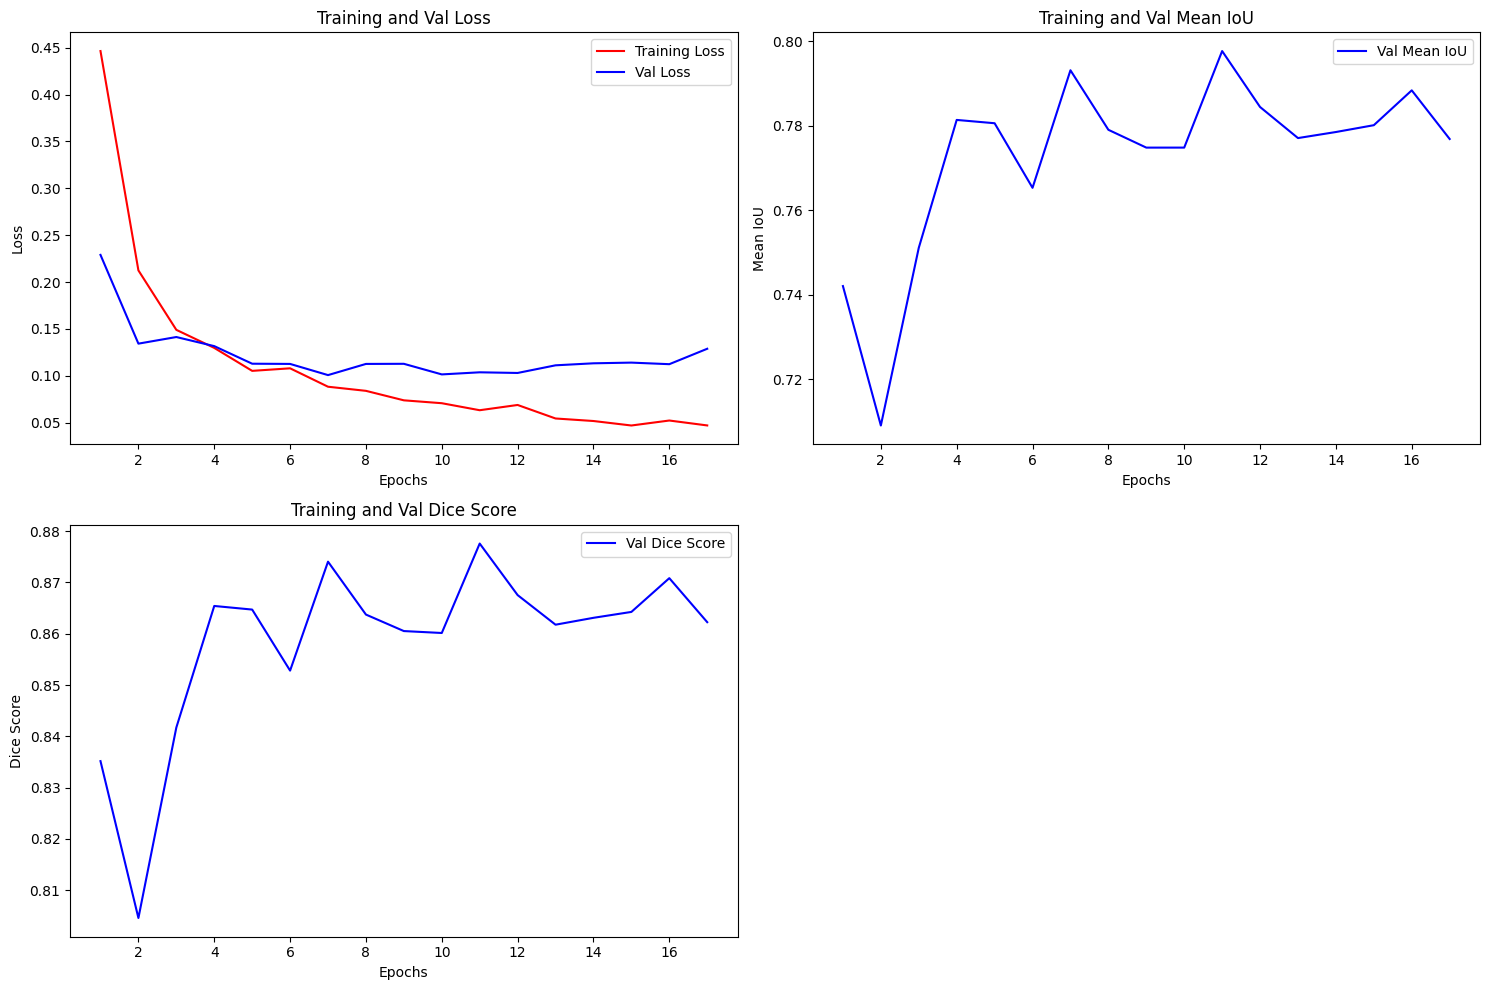

In [17]:
num_class = 1
n_workers = int(os.cpu_count())
# print(n_workers)
batch_size = 8
lr = 1e-4
epochs = 50
checkpoint = "/kaggle/working/tensorboard"
saved_model = "/kaggle/working/saved_model"

train(train_dataset, val_dataset, num_class, n_workers, batch_size, lr, epochs, checkpoint, saved_model)

## Inference

In [18]:
def pred_show_best_worst_per_label(model_pth, device, test_dataset, num_class, top_k=4):
    # Load model checkpoint
    checkpoint = torch.load(model_pth, map_location=device)
    
    # Initialize and load model state
    model_name = "nvidia/segformer-b3-finetuned-ade-512-512"
    model = SegformerForSemanticSegmentation.from_pretrained(model_name)
    in_channels = model.decode_head.classifier.in_channels
    model.decode_head.classifier = nn.Conv2d(in_channels, num_class, 1, 1)
    model.to(device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Dict to store per-category results
    results_by_label = {label: [] for label in test_dataset.categories}

    with torch.no_grad():
        for idx in range(len(test_dataset)):
            ori_img, orig_mask = test_dataset[idx]
            img = ori_img.float().to(device).unsqueeze(0)

            # Get logits and prob map
            logits = model(img).logits
            prob_mask = torch.sigmoid(upsample(logits)).squeeze().cpu().numpy()  # shape (H,W)
            pred_mask = (prob_mask >= 0.5).astype(np.uint8)
            
            # Predict mask
            pred_mask = upsample(model(img).logits).squeeze()
            pred_mask[pred_mask>=0.5] = 1
            pred_mask[pred_mask<0.5] = 0
            pred_mask = pred_mask.long()

            # Compute IoU
            intersection, union, _ = intersectionAndUnionGPU(pred_mask, orig_mask.long().to(device), K=num_class)
            iou = (intersection / (union + 1e-10)).mean().item()

            # Infer label from file path
            path = test_dataset.path[idx]
            label = os.path.basename(os.path.dirname(path))  # e.g., benign/malignant/normal

            # Reconstruct RGB image
            img_np = unNorm(ori_img).permute(1,2,0).numpy()  # shape (H,W,3), float in [0,1]
            img_uint8 = (img_np * 255).astype(np.uint8)

            # Generate heatmap
            heatmap = cv2.applyColorMap((prob_mask*255).astype(np.uint8), cv2.COLORMAP_JET)
            heatmap_overlay = cv2.addWeighted(img_uint8, 0.6, heatmap, 0.4, 0)

            results_by_label[label].append((
                idx, iou, img_uint8, orig_mask.numpy(), pred_mask.cpu().numpy(), heatmap_overlay
            ))

            # results_by_label[label].append((
            #     idx,
            #     iou,
            #     unNorm(ori_img).permute(1,2,0),
            #     orig_mask.numpy(),
            #     pred_mask.cpu().numpy()
            # ))

    # Plot best and worst per category
    for label, results in results_by_label.items():
        if not results:
            continue
        results.sort(key=lambda x: x[1])  # sort by IoU

        worst_samples = results[:top_k]
        best_samples = results[-top_k:]

        display_samples = worst_samples + best_samples

        fig = plt.figure(figsize=(24, 12))
        fig.suptitle(f"{label.upper()} - {top_k} Worst and {top_k} Best Predictions", fontsize=16)

        for i, (idx, iou, img, gt, pred, heatmap_overlay) in enumerate(display_samples, 1):
            fig.add_subplot(4, len(display_samples), i)
            plt.imshow(img)
            plt.title(f"Image {idx}\nIoU={iou:.4f}")
            plt.axis("off")

            fig.add_subplot(4, len(display_samples), i + len(display_samples))
            plt.imshow(gt, cmap="gray")
            plt.title("Ground Truth")
            plt.axis("off")

            fig.add_subplot(4, len(display_samples), i + 2*len(display_samples))
            plt.imshow(pred, cmap="gray")
            plt.title("Prediction")
            plt.axis("off")

            fig.add_subplot(4, len(display_samples), i + 3*len(display_samples))
            plt.imshow(heatmap_overlay)
            plt.title("Heatmap Overlay")
            plt.axis("off")

        plt.tight_layout()
        plt.show()


/tmp/ipykernel_177/989308853.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_pth, map_location=device)


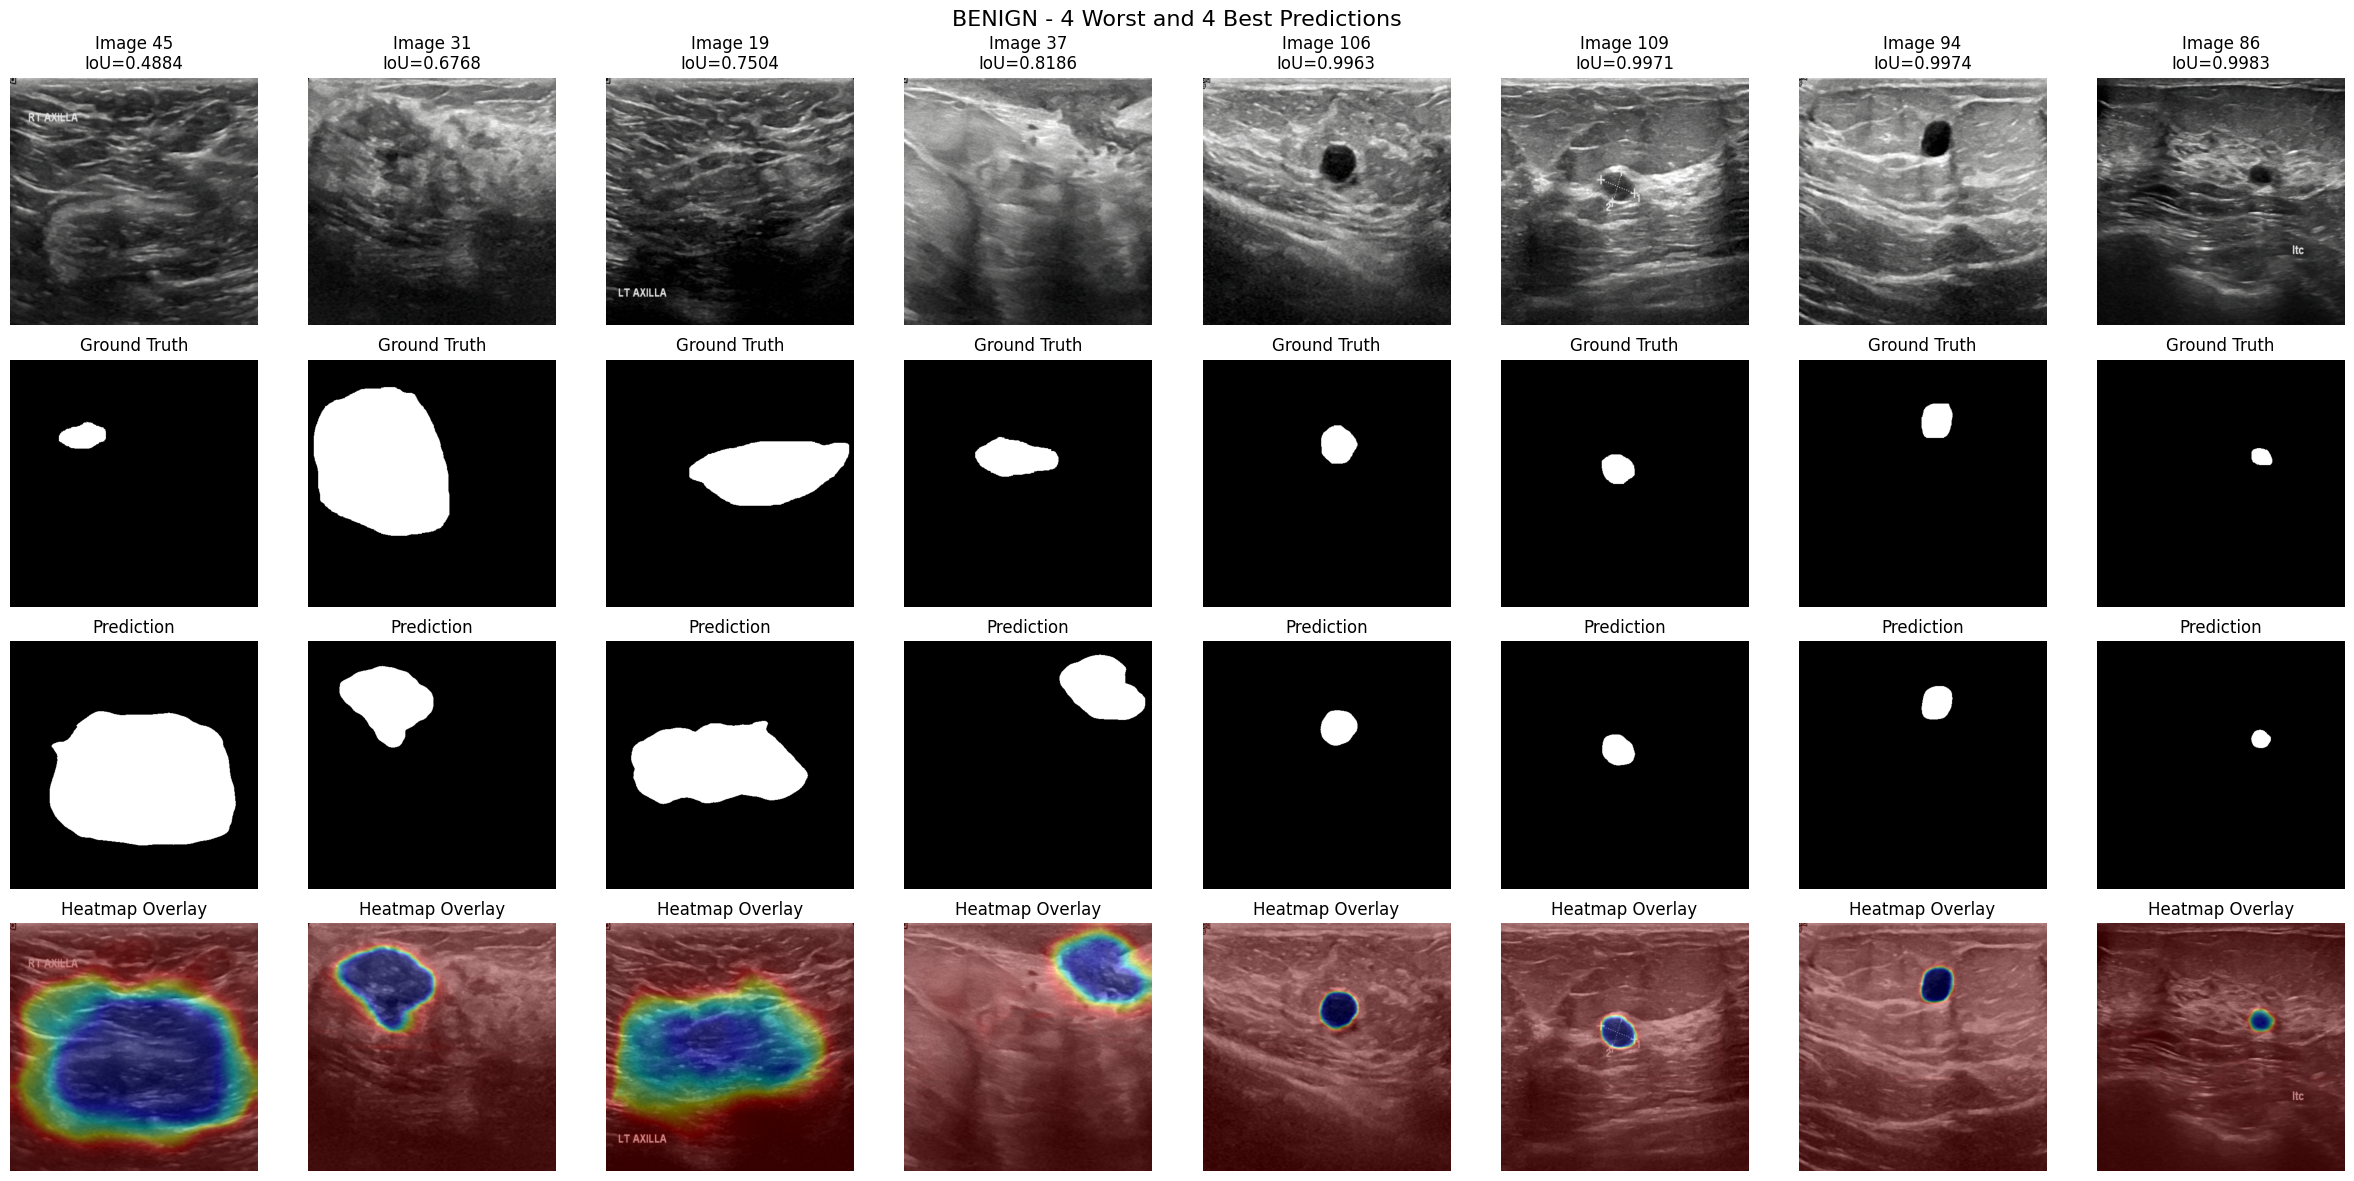

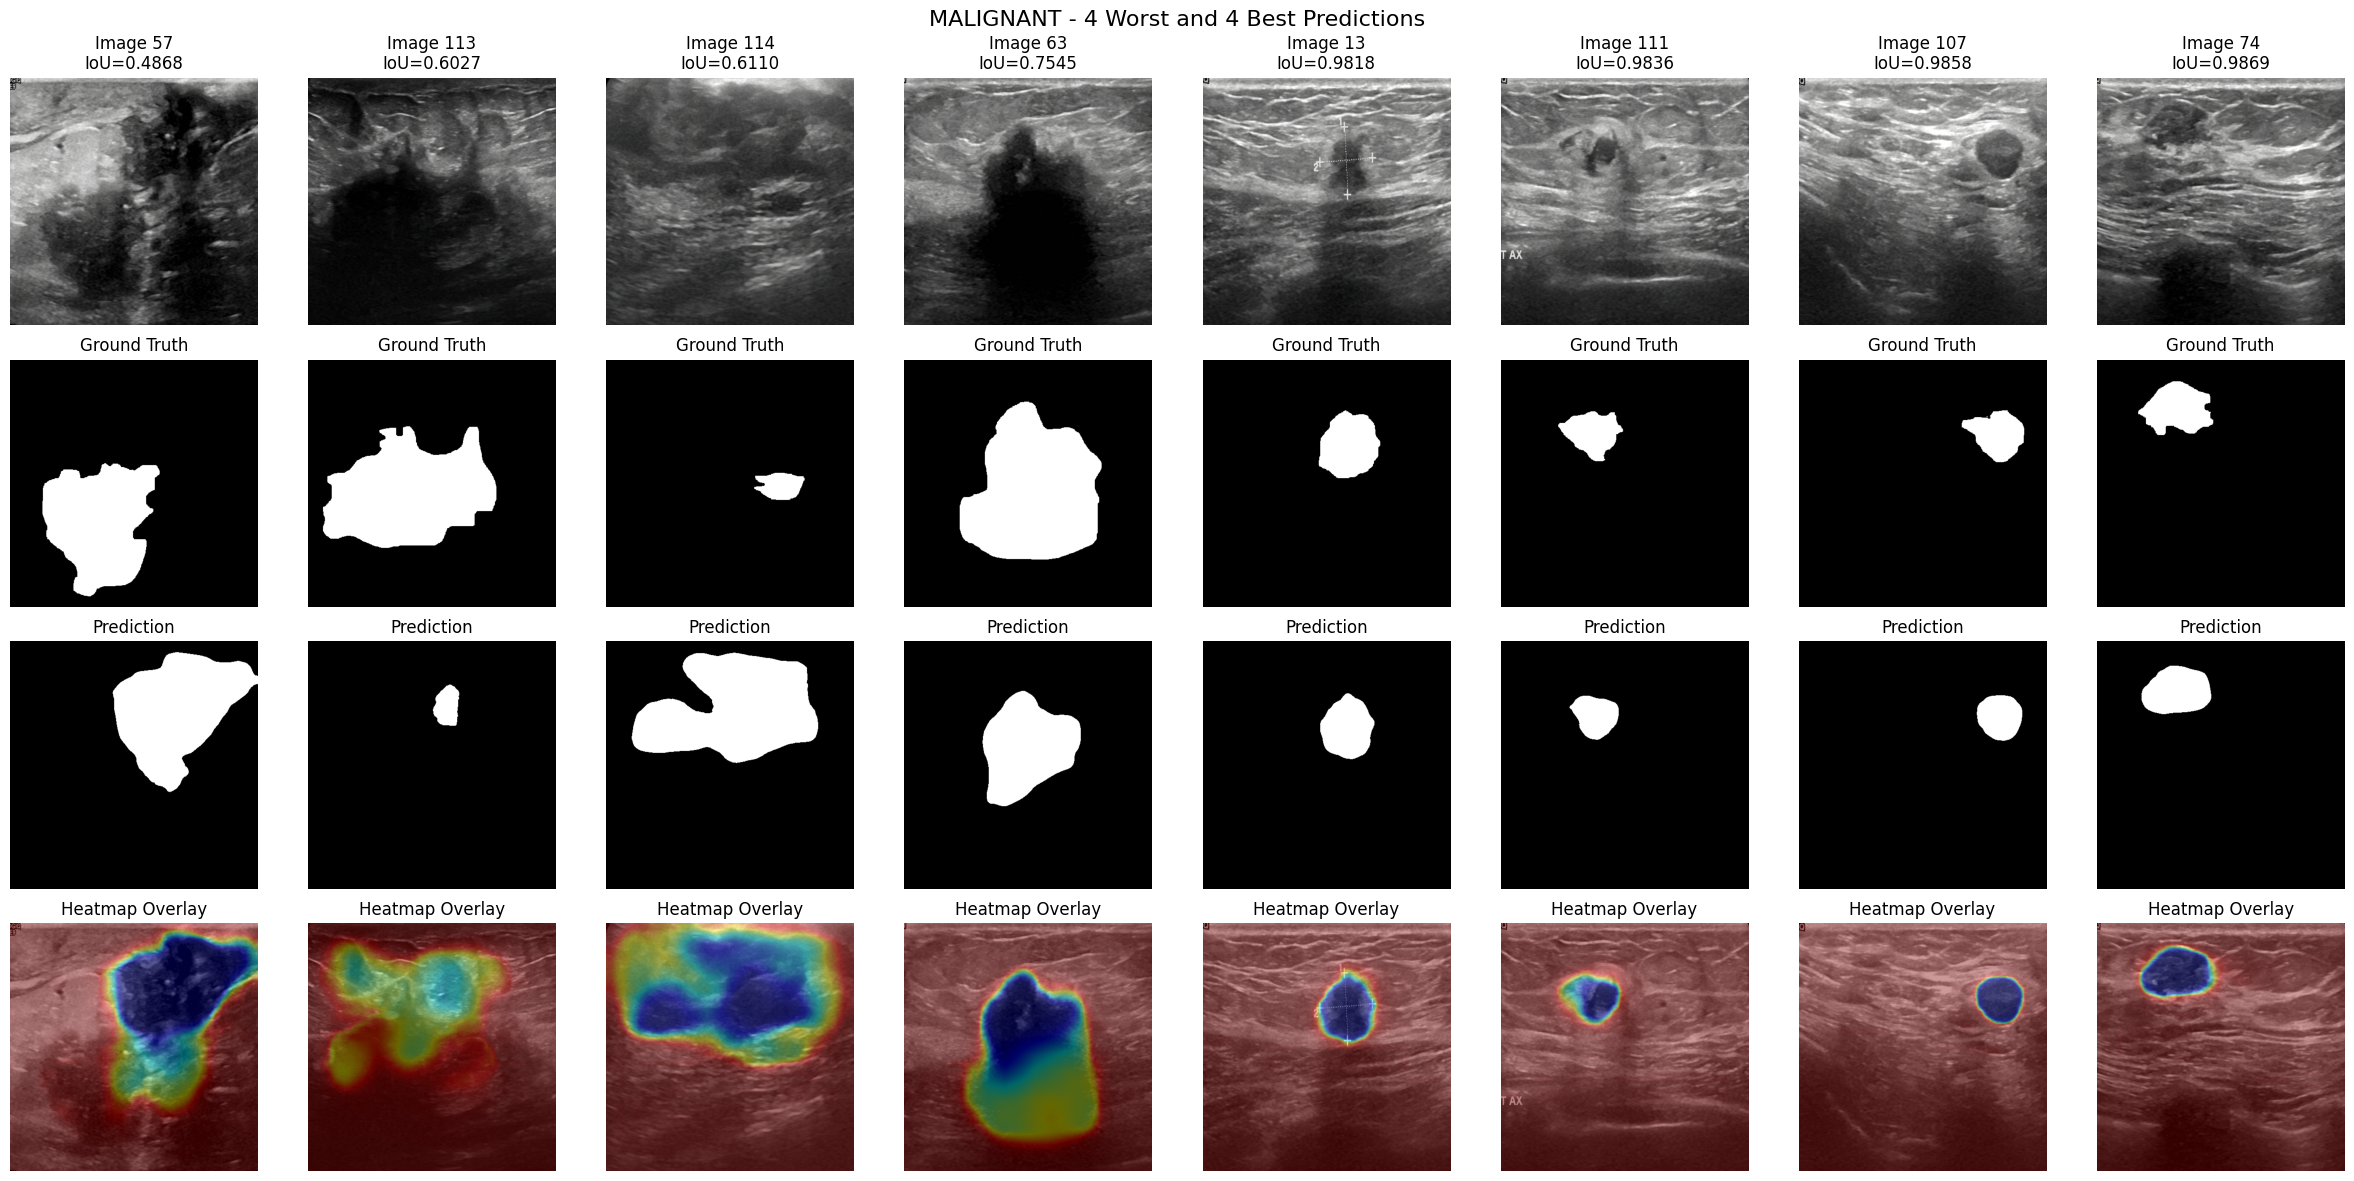

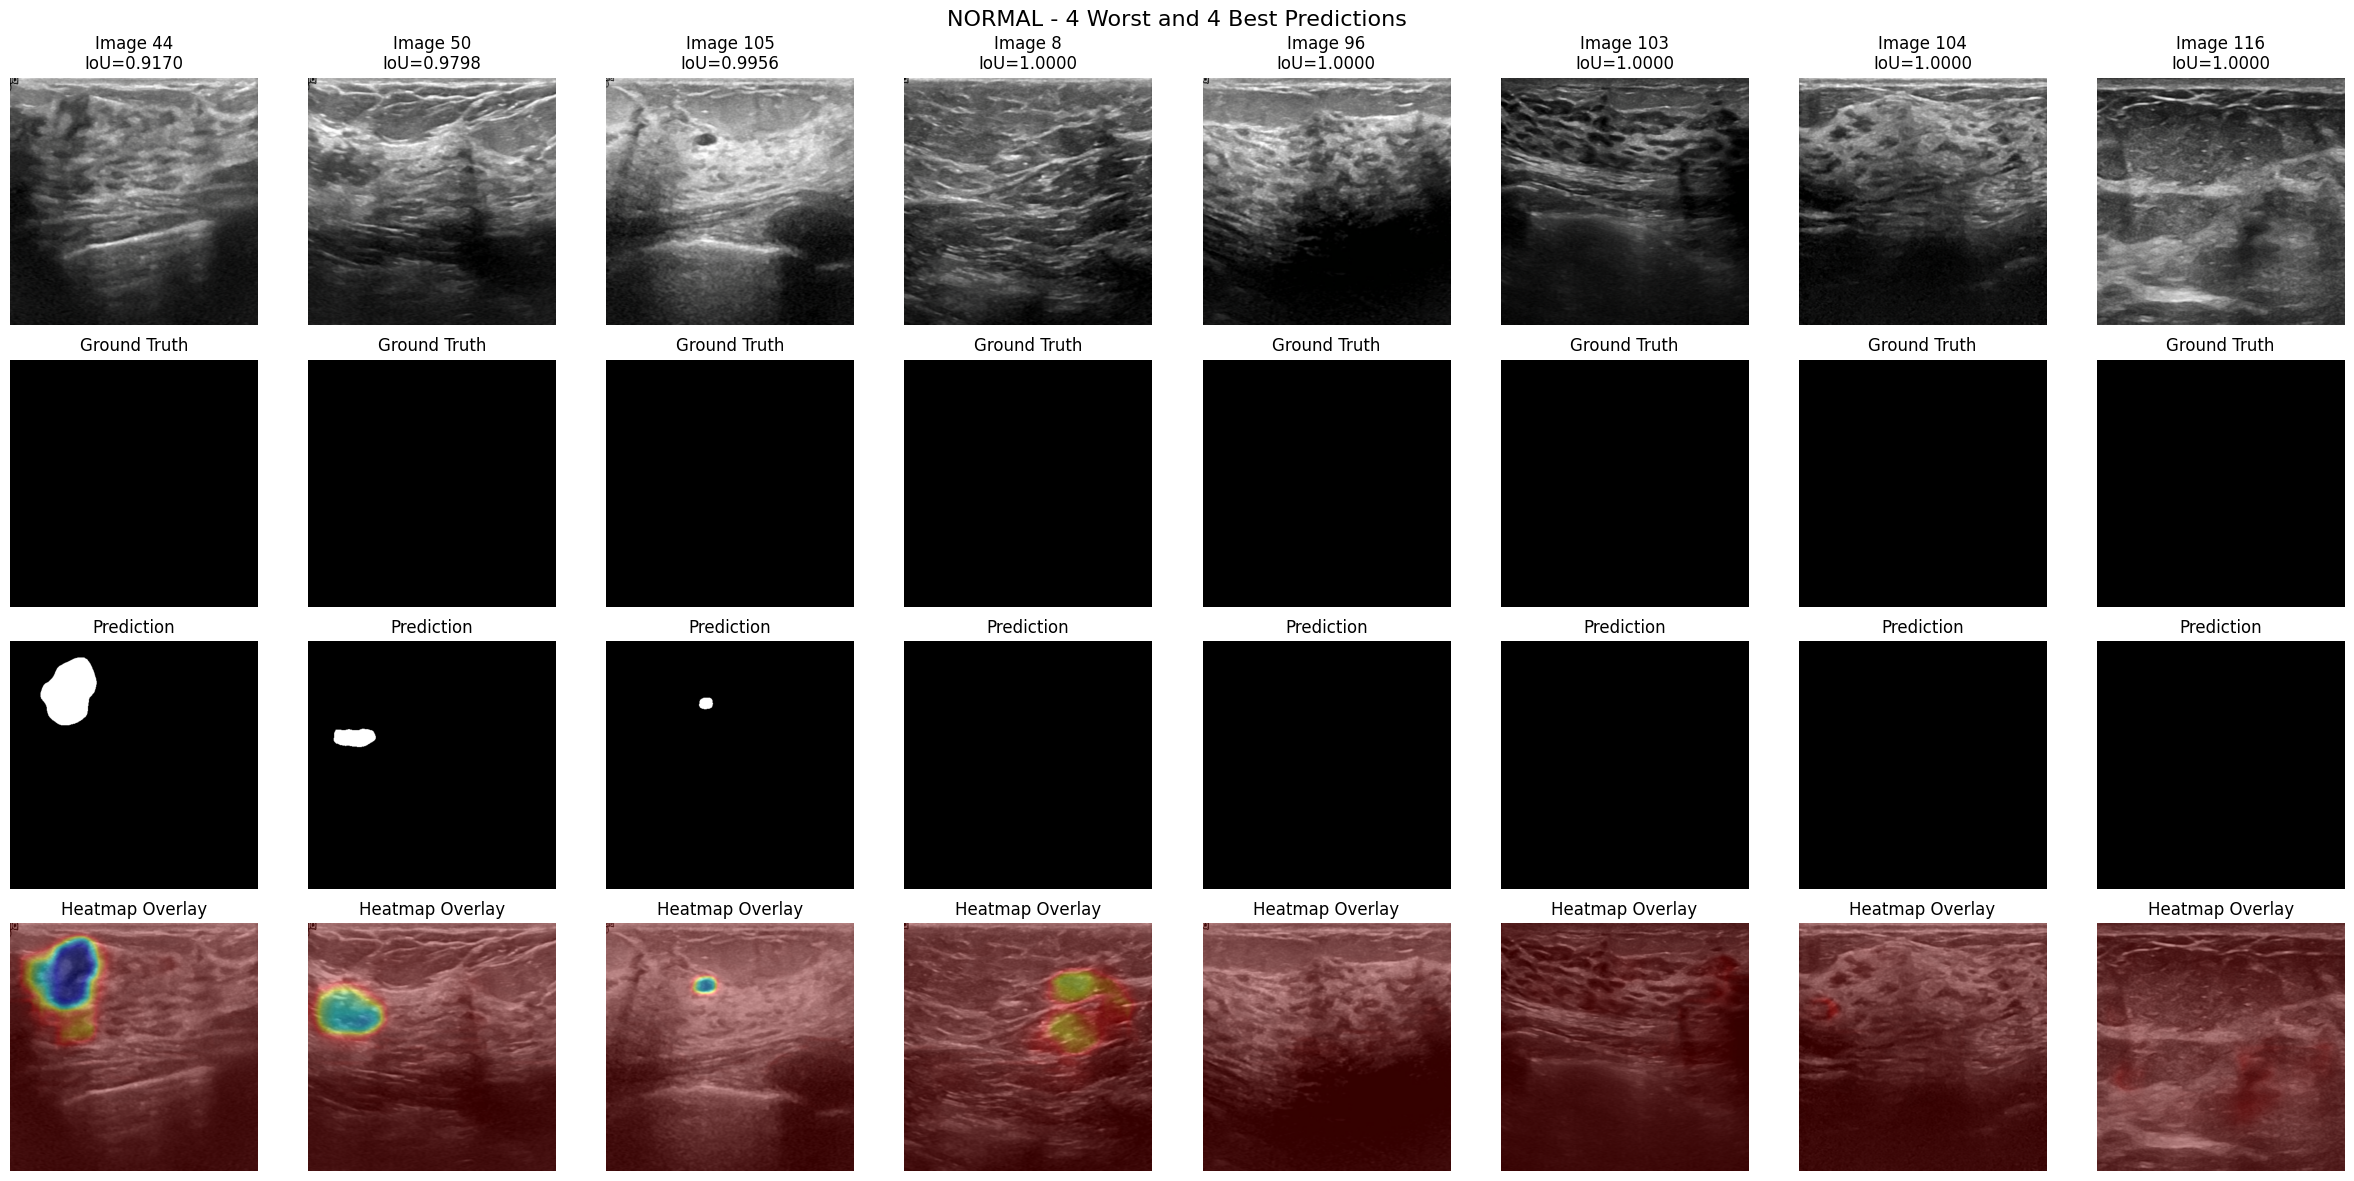

In [30]:
model_pth = "/kaggle/working/saved_model/best.pt"
pred_show_best_worst_per_label(model_pth, device, test_dataset, num_class, top_k=4)

In [20]:
len(test_dataset)

117

In [21]:
# def pred_show_image_grid(model_pth, device, test_dataset, num_classes, idx, num_imgs):
#     # Load model checkpoint
#     checkpoint = torch.load(model_pth)
    
#     # Initialize and load model state
#     model_name = "nvidia/segformer-b3-finetuned-ade-512-512"
#     model = SegformerForSemanticSegmentation.from_pretrained(model_name)
#     in_channels = model.decode_head.classifier.in_channels
#     model.decode_head.classifier = nn.Conv2d(in_channels, num_class, 1, 1)
#     model.to(device)
    
#     model.load_state_dict(checkpoint['model_state_dict'])
#     model.eval()
#     # Load validation dataset
    
#     images, orig_masks, pred_masks = [], [], []
    
#     with torch.no_grad():
#         for i in idx:
#             ori_img, orig_mask = test_dataset[i]
#             img = ori_img

#             # Predict mask
#             img = img.float().to(device).unsqueeze(0)
#             # (B, 21, H, W) -> (B, 1, H, W) -> (B, H, W)
#             pred_mask = upsample(model(img).logits).squeeze()
#             pred_mask[pred_mask>=0.5] = 1
#             pred_mask[pred_mask<0.5] = 0
#             pred_mask = pred_mask.long().cpu().numpy()

#             images.append(unNorm(ori_img).permute(1, 2, 0))
#             orig_masks.append(orig_mask)
#             pred_masks.append(pred_mask)

    
#     # Combine images and masks for display
#     images.extend(orig_masks)
#     images.extend(pred_masks)
    
#     # Plot images and masks
#     fig = plt.figure(figsize=(20, 10))
#     for i in range(1, 3*num_imgs + 1):
#         fig.add_subplot(3, num_imgs, i)
#         plt.imshow(images[i - 1])
#     plt.show()

In [22]:
# import random
# #Note: You must train the model before using this param
# model_pth = "/kaggle/working/saved_model/best.pt"
# print("\n")
# indexs = random.sample(range(len(test_dataset)), 8)
# print("indexs =", indexs)
# print("\n")

# #Show images
# pred_show_image_grid(model_pth, device, test_dataset, num_class, indexs, num_imgs= 8)

# Classification

In [23]:
class BreastCancerMaskDataset(Dataset):
    def __init__(self, root='/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT',
                 split="train", transform=None):
        self.categories = ["benign", "malignant", "normal"]
        self.transform = transform
        self.path = glob.glob(f"{root}/*/*_mask.png")
        
        random.seed(159)
        random.shuffle(self.path)
        
        total_len = len(self.path)
        train_end = int(total_len * 0.70)
        val_end = int(total_len * 0.85)
        
        if split == "train":
            self.path = self.path[:train_end]
        elif split == "val":
            self.path = self.path[train_end:val_end]
        elif split == "test":
            self.path = self.path[val_end:]
        else:
            raise ValueError("split must be 'train', 'val', or 'test'")

    def __len__(self):
        return len(self.path)

    def __getitem__(self, index):
        mask_path = self.path[index]
        label = os.path.basename(os.path.dirname(mask_path))
        label_idx = self.categories.index(label)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask[mask == 255] = 1  # ensure binary

        if self.transform:
            mask = self.transform(image=mask)["image"]

        return mask.float(), torch.tensor(label_idx, dtype=torch.long)


In [24]:
mask_transform = A.Compose([
    A.Resize(224,224),  # match ResNet input
    A.Normalize(mean=(0.5,), std=(0.5,)),  # single channel
    ToTensorV2()
])


In [25]:
class MaskClassifier(nn.Module):
    def __init__(self, num_classes=3):  # benign, malignant, normal
        super(MaskClassifier, self).__init__()
        # Use pretrained ResNet18
        self.resnet = models.resnet18(pretrained=True)
        # Change input conv to accept 1 channel (binary mask)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Replace final layer for 3-class classification
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [26]:
# Datasets
train_dataset = BreastCancerMaskDataset(split="train", transform=mask_transform)
val_dataset = BreastCancerMaskDataset(split="val", transform=mask_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MaskClassifier(num_classes=3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training
epochs = 50
best_val_acc = 0.0
patient = 5
patient_brake = 0

for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct, total = 0, 0
    
    for masks, labels in train_loader:
        masks, labels = masks.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(masks)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    train_acc = correct / total
    
    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    val_loss = 0
    with torch.no_grad():
        for masks, labels in val_loader:
            masks, labels = masks.to(device), labels.to(device)
            outputs = model(masks)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    val_acc = val_correct / val_total
    
    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {train_loss/len(train_loader):.4f}, Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss/len(val_loader):.4f}, Acc: {val_acc:.4f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "/kaggle/working/mask_classifier_best.pt")
        print("Saved Best Model!")
        patient_brake = 0
    else:
        patient_brake +=1

    if patient_brake > patient:
        print("Early brake initiated")
        break


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 190MB/s]


Epoch [1/50] Train Loss: 0.6838, Acc: 0.7344 Val Loss: 1.0891, Acc: 0.2393
Saved Best Model!
Epoch [2/50] Train Loss: 0.3189, Acc: 0.9139 Val Loss: 1.0349, Acc: 0.5641
Saved Best Model!
Epoch [3/50] Train Loss: 0.1733, Acc: 0.9469 Val Loss: 0.9650, Acc: 0.5470
Epoch [4/50] Train Loss: 0.1807, Acc: 0.9615 Val Loss: 1.8576, Acc: 0.2393
Epoch [5/50] Train Loss: 0.1866, Acc: 0.9505 Val Loss: 1.0694, Acc: 0.6325
Saved Best Model!
Epoch [6/50] Train Loss: 0.1448, Acc: 0.9670 Val Loss: 0.9817, Acc: 0.6068
Epoch [7/50] Train Loss: 0.0808, Acc: 0.9744 Val Loss: 0.2740, Acc: 0.8974
Saved Best Model!
Epoch [8/50] Train Loss: 0.1169, Acc: 0.9817 Val Loss: 6.9319, Acc: 0.2393
Epoch [9/50] Train Loss: 0.1532, Acc: 0.9487 Val Loss: 4.8379, Acc: 0.2393
Epoch [10/50] Train Loss: 0.0872, Acc: 0.9725 Val Loss: 1.9254, Acc: 0.3077
Epoch [11/50] Train Loss: 0.0677, Acc: 0.9817 Val Loss: 0.0766, Acc: 0.9744
Saved Best Model!
Epoch [12/50] Train Loss: 0.0289, Acc: 0.9890 Val Loss: 0.2333, Acc: 0.9231
Epoch [

In [27]:
model_pth = "/kaggle/working/saved_model/best.pt"
# Load SegFormer checkpoint
checkpoint = torch.load(model_pth, map_location=device)

model_name = "nvidia/segformer-b3-finetuned-ade-512-512"
segformer = SegformerForSemanticSegmentation.from_pretrained(model_name)

in_channels = segformer.decode_head.classifier.in_channels
segformer.decode_head.classifier = nn.Conv2d(in_channels, 1, kernel_size=1, stride=1)  # 1 class

segformer.load_state_dict(checkpoint["model_state_dict"])
segformer.to(device)
segformer.eval()

# Test on SegFormer predicted masks
# test_dataset = MaskOnlyDataset(root,split="test",transform=None)
model.load_state_dict(torch.load("/kaggle/working/mask_classifier_best.pt"))
model.eval()

all_preds,all_labels = [],[]

with torch.no_grad():
    for idx in range(len(test_dataset)):
        mask_path = test_dataset.path[idx]
        label = os.path.basename(os.path.dirname(mask_path))
        label_idx = test_dataset.categories.index(label)

        # load original test image
        from_dataset = cv2.imread(mask_path.replace("_mask.png",".png"))
        from_dataset = cv2.cvtColor(from_dataset, cv2.COLOR_BGR2RGB)
        from_dataset = A.Resize(512,512)(image=from_dataset)["image"]
        from_dataset = ToTensorV2()(image=from_dataset)["image"].float().unsqueeze(0).to(device)

        # SegFormer prediction
        pred_mask = F.interpolate(segformer(from_dataset).logits, size=(224,224), mode="bilinear", align_corners=False)
        pred_mask = torch.sigmoid(pred_mask).squeeze()
        pred_mask = (pred_mask >= 0.5).float().unsqueeze(0).unsqueeze(0)  # shape (1,1,H,W)
        pred_mask = (pred_mask - 0.5) / 0.5  # normalize like training

        # Classify predicted mask
        outputs = model(pred_mask.to(device))
        pred_class = outputs.argmax(1).item()

        all_preds.append(pred_class)
        all_labels.append(label_idx)

/tmp/ipykernel_177/1644282727.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_pth, map_location=device)
/tmp/ipykernel_177/1644282727.py:17

In [28]:
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

print("Classification on SegFormer Predicted Masks")
print(classification_report(all_labels, all_preds, target_names=test_dataset.categories))
print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))

Classification on SegFormer Predicted Masks
              precision    recall  f1-score   support

      benign       0.70      0.74      0.72        65
   malignant       0.00      0.00      0.00        32
      normal       0.35      0.85      0.50        20

    accuracy                           0.56       117
   macro avg       0.35      0.53      0.41       117
weighted avg       0.45      0.56      0.48       117

Confusion Matrix:
 [[48  0 17]
 [18  0 14]
 [ 3  0 17]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average="macro")
rec = recall_score(all_labels, all_preds, average="macro")
f1 = f1_score(all_labels, all_preds, average="macro")
print(f"Test Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))


Test Accuracy: 0.5556, Precision: 0.3499, Recall: 0.5295, F1: 0.4055
Confusion Matrix:
 [[48  0 17]
 [18  0 14]
 [ 3  0 17]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
